<a href="https://colab.research.google.com/github/amitmldlai/Book-Recommendation-System/blob/main/Generative_Adversarial_Network_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import datetime
tf.keras.backend.clear_session()
import glob
import matplotlib.pyplot as plt
import PIL
import os
from PIL import Image
import time
from tqdm import tqdm
from IPython import display
import warnings
warnings.filterwarnings("ignore")

In [1]:
!unzip /content/archive.zip

Extracting filenames





In [ ]:
file_name = list()
for filename in tqdm(glob.glob('/content/img_align_celeba/img_align_celeba/*.jpg')):
  file_name.append(filename)

100%|██████████| 202599/202599 [00:00<00:00, 2954305.96it/s]


Limiting the dataset to 2000 images for faster training

In [ ]:
file_path= file_name[0:20000]

Croping the image to capture the face of celebs in each image

In [ ]:
crop = (30, 55, 150, 175) 
images = [np.array((Image.open(path).crop(crop)).resize((64,64))) for path in file_path] 
images = np.array(images) 
images.shape

Normalizing the images between  [-1, 1]

In [ ]:
train_images = images.reshape(images.shape[0], 64, 64, 3, 1).astype('float32')
train_images = (train_images -127.5) / 127.5 
train_images.shape

Convert train_images into a tf.data.Dataset 

In [ ]:
BUFFER_SIZE = 20000
BATCH_SIZE = 256

# Batch and shuffle the data
# Refer: https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices
'''
Creates a Dataset whose elements are slices of the given tensors. 
The given tensors are sliced along their first dimension.
'''
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(train_dataset)

<BatchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3, 1), dtype=tf.float32, name=None)>


Generator Model

In [ ]:
def make_generator_model():
    generator=tf.keras.Sequential()

    generator.add(layers.Dense(4*4*512,input_shape=[100]))
    generator.add(layers.Reshape([4,4,512]))
 
    generator.add(layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"))
    generator.add(layers.LeakyReLU(alpha=0.2))
    generator.add(layers.BatchNormalization())

    generator.add(layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"))
    generator.add(layers.LeakyReLU(alpha=0.2))
    generator.add(layers.BatchNormalization())

    generator.add(layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"))
    generator.add(layers.LeakyReLU(alpha=0.2))
    generator.add(layers.BatchNormalization())

    generator.add(layers.Conv2DTranspose(3, kernel_size=4, strides=2, padding="same",
                                    activation='tanh'))
    return generator

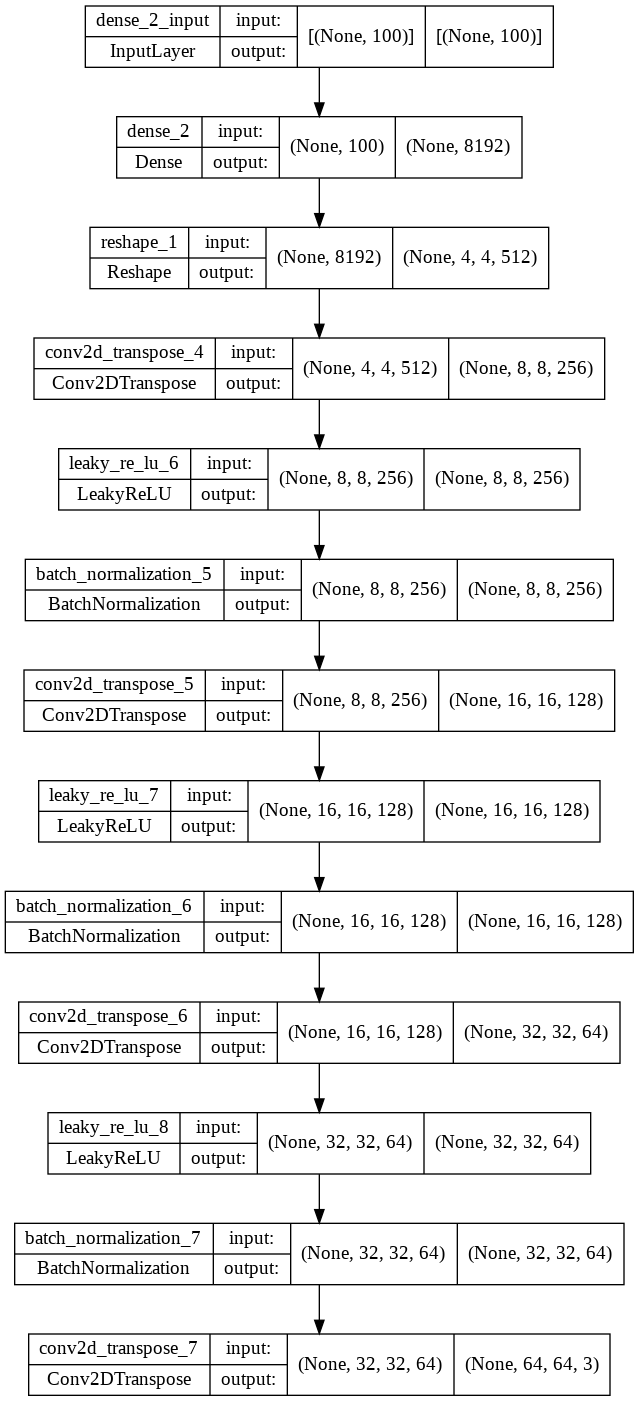

In [ ]:
generator = make_generator_model()
keras.utils.plot_model(generator, 'generator.png', show_shapes=True)

Forward-pass through the generator

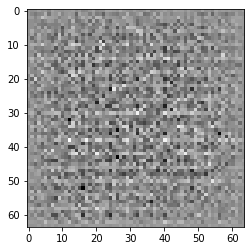

In [ ]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

Discriminator Model

In [ ]:
def make_discriminator_model():
  discriminator= tf.keras.Sequential()
  discriminator.add(layers.Conv2D(32, kernel_size=4, strides=2, padding="same",input_shape=[64,64, 3]))

  discriminator.add(layers.Conv2D(64, kernel_size=4, strides=2, padding="same"))
  discriminator.add(layers.LeakyReLU(0.2))
  discriminator.add(layers.BatchNormalization())

  discriminator.add(layers.Conv2D(128, kernel_size=4, strides=2, padding="same"))
  discriminator.add(layers.LeakyReLU(0.2))
  discriminator.add(layers.BatchNormalization())

  discriminator.add(layers.Conv2D(256, kernel_size=4, strides=2, padding="same"))
  discriminator.add(layers.LeakyReLU(0.2))

  discriminator.add(layers.Flatten())
  discriminator.add(layers.Dropout(0.5))
  discriminator.add(layers.Dense(1))

  return discriminator

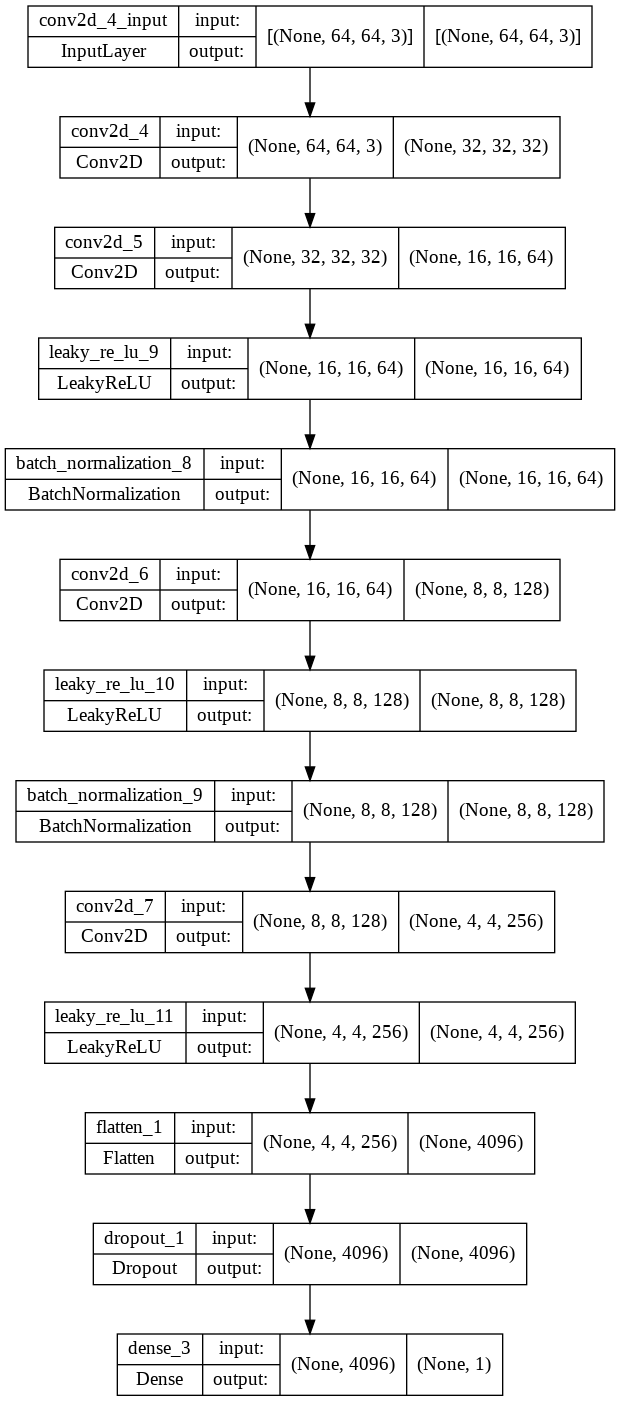

In [ ]:
discriminator = make_discriminator_model()
keras.utils.plot_model(discriminator, 'discriminator.png', show_shapes=True)

Forward-pass through discriminator model, not trained yet

In [ ]:
decision = discriminator(generated_image) 
print (decision)

tf.Tensor([[-0.03973623]], shape=(1, 1), dtype=float32)


#Loss functions

In [ ]:
# Loss: Binary CrossEntropy <=> log-loss
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

Discrimanator Loss

In [ ]:
# For the discrimanator,  0 => fake and 1 => real image
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output) # tf.ones creates a tensor of ones
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output) # tf.zeros creates a tensor of zeros
    total_loss = real_loss + fake_loss
    return total_loss

Generator Loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

Setting Optimizers and Checkpoints

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator) # what objects to store in a ckpt

Creating 20 samples of random noise from normal distribution

In [ ]:
EPOCHS = 420 
noise_dim = 100
num_examples_to_generate = 20
# We will reuse these test_random_vectors overtime (so it's easier)
# to visualize progress in the animated GIF)
test_random_vectors = tf.random.normal([num_examples_to_generate, noise_dim])
print(test_random_vectors.shape)

(20, 100)


Training utilities

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled" into a TF Graph
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      gen_loss, disc_loss = train_step(image_batch)
     
    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch + 1, test_random_vectors, gen_loss, disc_loss)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, test_random_vectors, gen_loss, disc_loss)

Generating and saving the the images from trained model

In [ ]:
def generate_and_save_images(model, epoch, test_input, gen_loss, disc_loss):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)
  fig = plt.figure(figsize=(8, 8))
  for i in range(predictions.shape[0]):
      plt.subplot(4, 5, i+1)
      plt.imshow(tf.cast((predictions[i]* 127.5) + 127.5, tf.uint8))
      plt.axis('off')
  print('Generative Model loss: '+ str(gen_loss.numpy()))
  print('Discriminator Model loss: ' + str(disc_loss.numpy()))  

  plt.savefig('image3_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
train(train_dataset, EPOCHS)